In [1]:
%pylab --no-import-all inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys

In [4]:
#
# Poniższy kod dedykuje twórcom Windowsa (https://github.com/erocarrera/pydot/issues/91)
#
if sys.platform == 'win32':
    print "Monkey-patching pydot"
    import pydot

    def force_find_graphviz(graphviz_root):
       binpath = os.path.join(graphviz_root, 'bin')
       programs = 'dot twopi neato circo fdp sfdp'
       def helper():
         for prg in programs.split():
           if os.path.exists(os.path.join(binpath, prg)):
             yield ((prg, os.path.join(binpath, prg)))
           elif os.path.exists(os.path.join(binpath, prg+'.exe')):
             yield ((prg, os.path.join(binpath, prg+'.exe')))
       progdict = dict(helper())
       return lambda: progdict

    pydot.find_graphviz = force_find_graphviz('c:/Program Files (x86)/Graphviz2.34/')

In [5]:
import theano
import theano.tensor as TT
import theano.printing as TP

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 780


In [6]:
from IPython.display import SVG
def svgdotprint(g):
    return SVG(theano.printing.pydotprint(g, return_image=True, format='svg'))

## Co robi Theano?

W Theano definiujemy *zmienne **symboliczne*** które łączymy za pomocą wyrazeń arytmetycznych w *graf obliczeń*. Grafy możemy przekształcać (np. różniczkować) i kompilować.

In [7]:
#Operacje na skalarach

x = TT.scalar('X')
y = TT.scalar('y')
z = x + y

In [9]:
# x reprezenuje liczbę w grafie obliczeń. Sam z siebie nie posiada wartości.

x

X:TensorType(float32, scalar)

In [10]:
type(x)

theano.tensor.var.TensorVariable

In [11]:
# z jest grafem obliczeń (technicznie dla Theano wciąż jest zmienną symboliczną)

z

Elemwise{add,no_inplace}.0:TensorType(float32, scalar)

In [12]:
type(z)

theano.tensor.var.TensorVariable

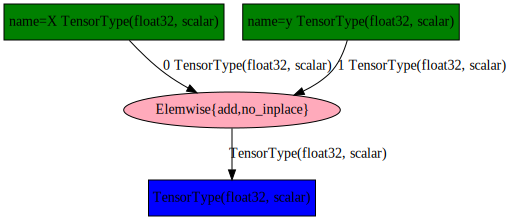

In [13]:
svgdotprint(z)

In [13]:
print theano.config.base_compiledir

/tmp/jch/theano.NOBACKUP


In [14]:
# Kompilacja grafu z do funkcji

f_z = theano.function([x,y],z)

In [15]:
f_z(1.0,4.0)

5.0

Co się właśnie wydarzyło? 

Theano wzięło graf definijący `z`, uruchomiło optymalizację i utworzyło funkcję obliczającą wartość `z`. Do funkcji został wygenerowany kod w C.


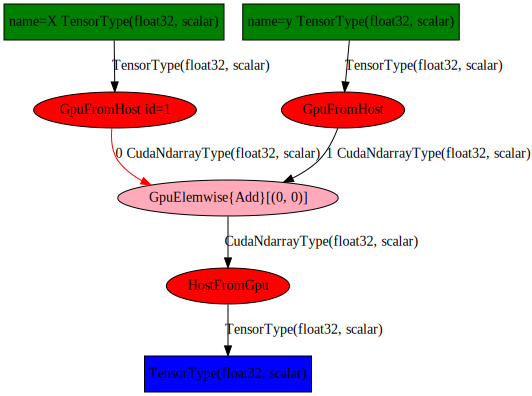

In [16]:
svgdotprint(f_z.maker.fgraph.outputs[0])

In [23]:
# macierze delkarujemy analogicznie do skalarów

x = TT.matrix('x')
y = TT.matrix('y')
z = x.dot(y)

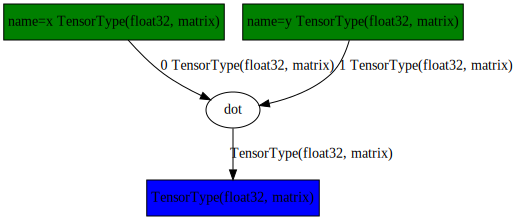

In [24]:
svgdotprint(z)

In [25]:
f_z = theano.function([x,y],z, allow_input_downcast=True,
                      accept_inplace=True)

In [26]:
f_z(1.0,2.0)

TypeError: ('Bad input argument to theano function with name "<ipython-input-25-60ca36cd090f>:2"  at index 0(0-based)', 'Wrong number of dimensions: expected 2, got 0 with shape ().')

In [ ]:
f_z(np.ones((10,10)),np.random.rand(10,10)) #teraz dobrze - theano przekaże argumenty np.array, które zamieni zagnieżdżone listy na macierze

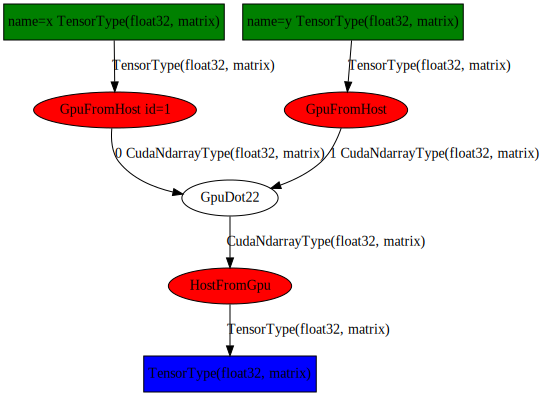

In [27]:
svgdotprint(f_z)

In [37]:
N=2000
X=np.random.rand(N,N).astype('float32')
Y=np.random.rand(N,N).astype('float32')

In [38]:
%timeit Z = X.dot(Y)

10 loops, best of 3: 110 ms per loop


In [39]:
%timeit ZT = f_z(X,Y)

100 loops, best of 3: 12.6 ms per loop


In [41]:
!nvidia-smi

Thu Jun 11 10:32:12 2015       
+------------------------------------------------------+                       
| NVIDIA-SMI 346.47     Driver Version: 346.47         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 780     Off  | 0000:01:00.0     N/A |                  N/A |
| 41%   54C    P0    N/A /  N/A |    124MiB /  3071MiB |     N/A      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [40]:
Z = X.dot(Y)
ZT = f_z(X,Y)
D = Z-ZT
print (np.abs(D)).max()
print (np.abs(D/Z)).max()

0.00149536
3.02462e-06


In [42]:
#Optymalizacja

z2 = TT.log(x**2 + y)

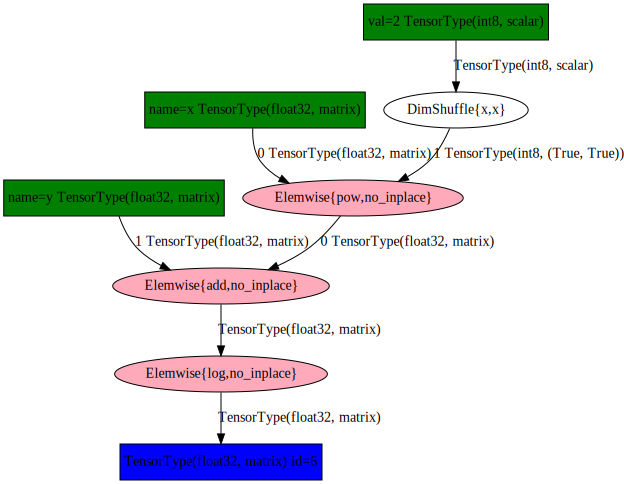

In [43]:
svgdotprint(z2)

In [44]:
f2 = theano.function([x,y],z2)

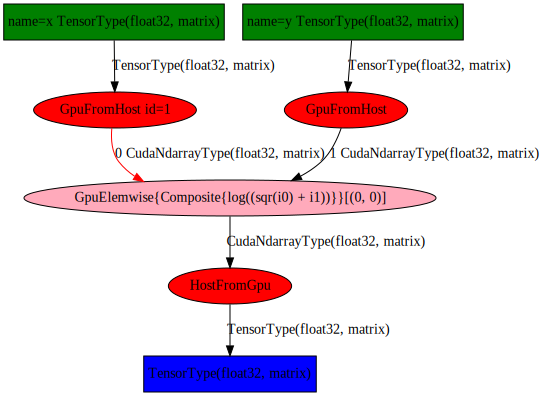

In [45]:
#operacje na skalarach sa połączone!
#svgdotprint(f2.maker.fgraph.outputs[0])
svgdotprint(f2) #to samo co powyżej

###Typy w Theano

Theano posiada system typów podobny do numpy. Każda zmienna symboliczna posiada typ przechowywanych wartości (`dtype`), ilosć wymiarów i informacje czy wzdłuż danego wymiar można broadcastować.

In [27]:
x.type

TensorType(float32, matrix)

Theano posiada kilka najpopularniejszych typów tablic - w tym macierz. Pełna lista jest tu: http://deeplearning.net/software/theano/library/tensor/basic.html#all-fully-typed-constructors

In [28]:
#matrix nie broadcastuje
x.broadcastable

(False, False)

In [29]:
v = TT.vector('v')

In [30]:
v.type

TensorType(float32, vector)

In [31]:
v.broadcastable

(False,)

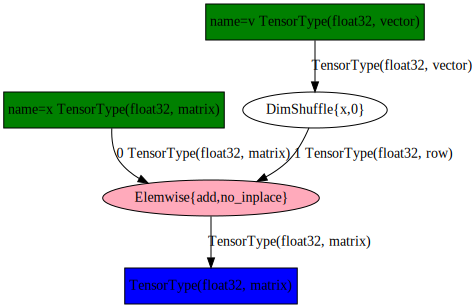

In [32]:
#Tu widzimy, że podobnie jak w numpy zmienna o mniejszej ilości wymiarów traktowana jest, jakby miała z lewej jednostkowe broadcastowalne wymiary
svgdotprint(x+v)

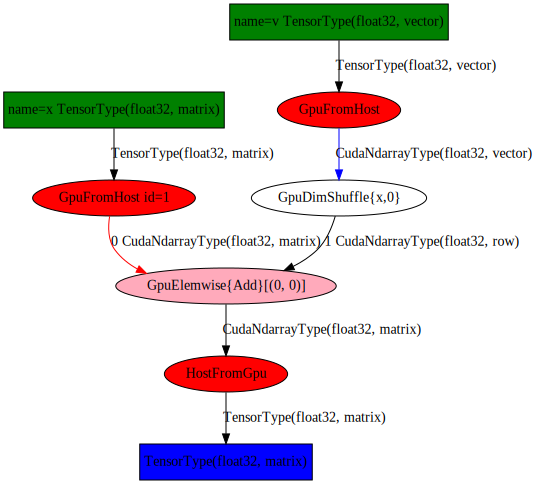

In [33]:
f_x_v = theano.function([x,v], x+v)
svgdotprint(f_x_v)

In [34]:
f_x_v(np.ones((3,3), dtype=np.float32), np.arange(3, dtype=np.float32))

Shape: (3, 3)
[[ 1.  2.  3.]
 [ 1.  2.  3.]
 [ 1.  2.  3.]]

In [35]:
v2 = v.reshape((1,v.shape[0])) #dodanie wymiaru jednostkowego pozwala na broadcasting
v2.broadcastable

(True, False)

In [36]:
v3 = TT.unbroadcast(v2,0) #teraz nie wolno broadcastować
v3.broadcastable

(False, False)

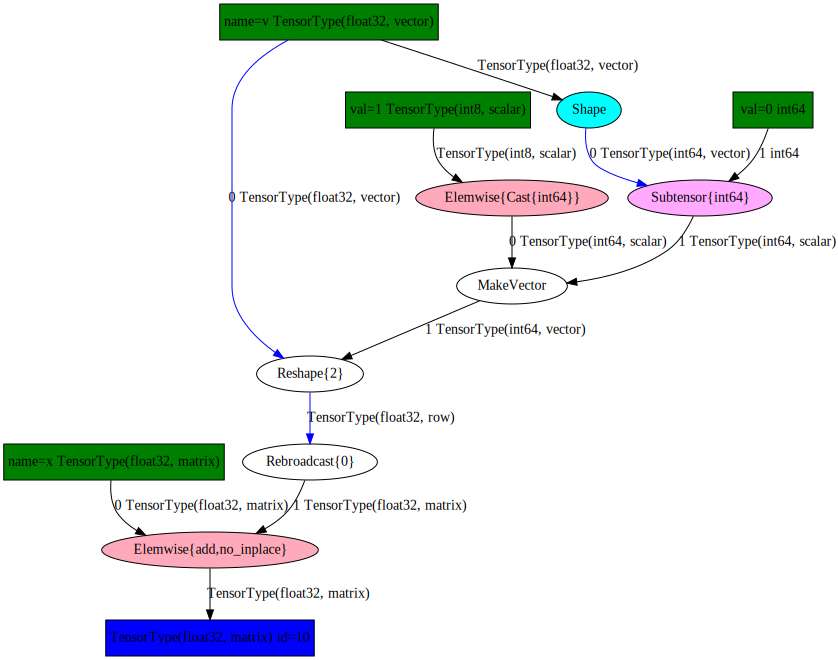

In [37]:
svgdotprint(x+v3)

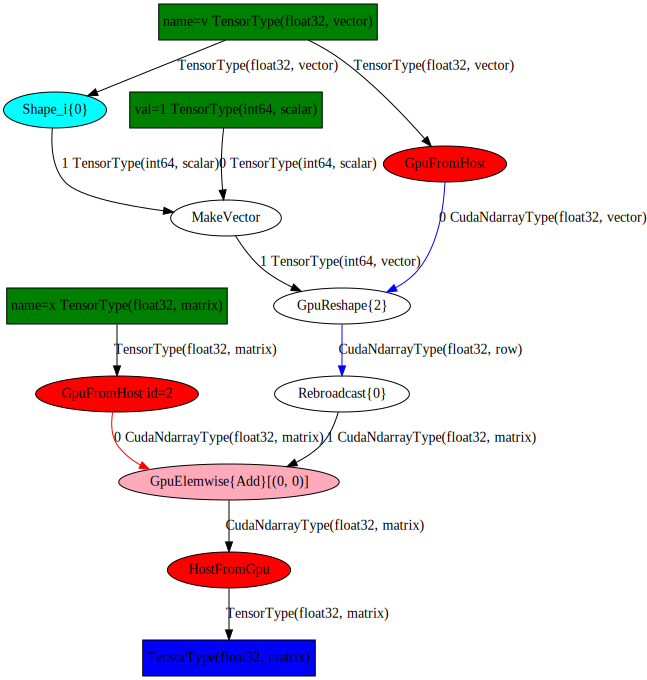

In [38]:
f_x_v3 = theano.function([x,v],x+v3)
svgdotprint(f_x_v3)

In [39]:
f_x_v3(np.ones((2,3), dtype=np.float32), np.arange(3, dtype=np.float32))

ValueError: GpuElemwise. Input dimension mis-match. Input 1 (indices start at 0) has shape[0] == 1, but the output's size on that axis is 2.
Apply node that caused the error: GpuElemwise{Add}[(0, 0)](GpuFromHost.0, Rebroadcast{0}.0)
Inputs types: [CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix)]
Inputs shapes: [(2, 3), (1, 3)]
Inputs strides: [(3, 1), (0, 1)]
Inputs values: ['not shown', <CudaNdarray object at 0x7f7c5eabaef0>]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## debugowanie w Theano

Błędy w kodzie Theano najczęściej wykrywane sa dopiero podczas uruchomienia. Znalezienie błędnej linijki jest wtedy nie lada wyzwaniem. Z pomocą przychodzą wartości testowe - każdą zmienną możemy zaopatrzyć w wartość testową, na której operacje wykonywane są natychmiast:

In [46]:
theano.config.compute_test_value = 'warn' #błędy w obliczeniach na wartościach testowych wypiszą ostrzeżenia

In [47]:
x = TT.matrix()
x.tag.test_value = np.arange(12.0, dtype=np.float32).reshape(3,4)

In [48]:
x.tag.test_value

Shape: (3, 4)
[[  0.   1.   2.   3.]
 [  4.   5.   6.   7.]
 [  8.   9.  10.  11.]]

In [49]:
v = TT.vector()
v.tag.test_value = np.arange(3., dtype=np.float32)/10

In [50]:
x+v #teraz szybko łapiemy błędy

ValueError: Input dimension mis-match. (input[0].shape[1] = 4, input[1].shape[1] = 3)

In [51]:
z = x + v.dimshuffle(0,'x')
z.tag.test_value

Shape: (3, 4)
[[  0.           1.           2.           3.        ]
 [  4.0999999    5.0999999    6.0999999    7.0999999 ]
 [  8.19999981   9.19999981  10.19999981  11.19999981]]

## Theano umie różniczkować

In [52]:
theano.config.compute_test_value = 'off' #wyłaczamy

In [53]:
x = TT.scalar('x')

In [54]:
y = x**2 

In [55]:
dy_dx = TT.grad(y,x)

In [56]:
TP.pp(dy_dx) #przed optymalizacją niewiele widać

'((fill((x ** TensorConstant{2}), TensorConstant{1.0}) * TensorConstant{2}) * (x ** (TensorConstant{2} - TensorConstant{1})))'

In [57]:
f_dy_dx = theano.function([x],dy_dx) #niestety nie wiem, jak odpalić optymalizację bez kompilacji funkcji...
TP.pprint(f_dy_dx.maker.fgraph.outputs[0])

'HostFromGpu(GpuElemwise{Mul}[(0, 1)](CudaNdarrayConstant{2.0}, GpuFromHost(x)))'

## Theano zna też rachunek różniczkowy na macierzach

In [52]:
x = TT.matrix('x')
v = TT.vector('v')

y = v.dot(x).sum()

In [53]:
dy_dx = TT.grad(y,x)

In [54]:
TP.pp(dy_dx) 

'(DimShuffle{0, x}(v) \\dot fill((v \\dot x), fill(Sum{acc_dtype=float64}((v \\dot x)), TensorConstant{1.0})))'

In [55]:
f_dy_dx = theano.function([x,v],dy_dx) #niestety nie wiem, jak odpalić optymalizację bez kompilacji funkcji...
TP.pprint(f_dy_dx.maker.fgraph.outputs[0])

'HostFromGpu(GpuGer{inplace}(GpuAlloc{memset_0=True}(CudaNdarrayConstant{0.0}, Shape_i{0}(v), Shape_i{1}(x)), TensorConstant{1.0}, GpuFromHost(v), GpuDimShuffle{1}(GpuAlloc(CudaNdarrayConstant{Shape: (1, 1)\n[[ 1.]]}, TensorConstant{1}, Shape_i{1}(x)))))'

In [56]:
theano.gradient.jacobian(v.dot(x), x)

for{cpu,scan_fn}.0:TensorType(float32, 3D)

## Zmienne współdzielone (shared) - stan funkcji

Na razie umiemy w Theano zapisać jedynie funkcje bez stanu. `shared variables` pozwalają na dodanie ukrytego stanu funkcji. Dzieki nim będziemy mogli łatwo implementować modele uczące się - dopasowywane parametry zakodujemy jako shared variables.

In [57]:
s = theano.shared(np.random.rand(3,3).astype(np.float32))

In [58]:
s

<CudaNdarrayType(float32, matrix)>:CudaNdarrayType(float32, matrix)

In [59]:
s.type

CudaNdarrayType(float32, matrix)

In [60]:
s.broadcastable

(False, False)

Na pierwszy rzut oka `s` jest zwykłą zmienną symboliczną. Jednak `s` posiada wartości - jest zmienną którą możemy czytać i do której możemy pisać:

In [61]:
s.get_value()

Shape: (3, 3)
[[ 0.18300894  0.62730706  0.45276999]
 [ 0.00842668  0.45045659  0.78276771]
 [ 0.28307703  0.41000003  0.962367  ]]

In [62]:
s.set_value(np.zeros((3,3), dtype=np.float32))

In [63]:
s.get_value(borrow=True) #borrow mówi, żeby zwrócić widok pamięci związanej z shared variable. To trochę przyspiesza kod
                         #gdy zmienne sa duże

Shape: (3, 3)
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

In [64]:
aa = s.get_value(borrow=True)
aa[0,0]=10

In [65]:
s.get_value()

Shape: (3, 3)
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

In [65]:
# s możemy używać jak każdej innej zmiennej symbolicznej:

f_s = theano.function([], 2*s)

In [66]:
f_s()

Shape: (3, 3)
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

In [67]:
s.set_value(np.ones((3,3), dtype=np.float32))

In [68]:
f_s()

Shape: (3, 3)
[[ 2.  2.  2.]
 [ 2.  2.  2.]
 [ 2.  2.  2.]]

In [69]:
# operacje arytmetyczne w Theano zasadniczo nie mają skutków ubocznych.
# Aby zmienić wartość shared variable możemy zadeklarować listę zmian w wywołanu theano.function:

ctr = theano.shared(0)

f_ctr = theano.function([],ctr, updates=[(ctr, ctr+1)]) #uwaga - updates wykonuja się z zadanej kolejności!

In [70]:
f_ctr()

0

In [71]:
ctr.get_value()

1

In [72]:
ctr.set_value(-10)

In [73]:
f_ctr()

-10

In [74]:
x = TT.matrix('x')
x_stary = x
x += 1 

x_stary is x

False

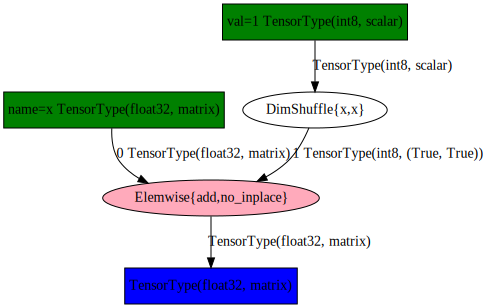

In [75]:
svgdotprint(x)

In [76]:
f_weird = theano.function([x],x)
f_weird(np.ones((3,3), dtype=np.float32))

Shape: (3, 3)
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]

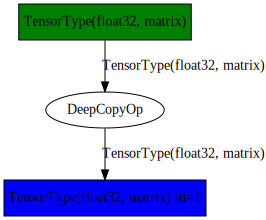

In [77]:
svgdotprint(f_weird)

In [78]:
x = theano.shared(np.ones((3,3), dtype=np.float32))
x += 1

In [79]:
f_x = theano.function([],x)

In [80]:
f_x()

Shape: (3, 3)
[[ 2.  2.  2.]
 [ 2.  2.  2.]
 [ 2.  2.  2.]]

# Łączymy klocki - regresja logistyczna w Theano

In [58]:
#dane mnist

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [59]:
trainX, testX = np.split((mnist.data).astype(np.float32), [60000])
trainY, testY = np.split(mnist.target.astype(np.int32), [60000])

In [60]:
trainX_mean = trainX.mean(0, keepdims=True)
trainX_std = trainX.std(0, keepdims=True)
trainX_std[trainX_std<1e-4] = 1.0
trainX = (trainX-trainX_mean)/trainX_std
testX = (testX-trainX_mean)/trainX_std

In [69]:
theano.config.compute_test_value = 'warn' #właczamy

In [70]:
X = TT.matrix() #zmienne niezależne - minibatch
X.tag.test_value = trainX[:2,:] #weźmiemy tylko dwie wartości, żeby szybko sie liczyło

In [71]:
Y = TT.ivector() #Y będzie typu integer
Y.tag.test_value = trainY[:2]

In [72]:
# wagi - będziemy na początku wykrywać tylko jedynki. Potrzebujemy więc jednego zestawu wag
W = theano.shared((np.random.randn(trainX.shape[1], 1) * 0.05).astype(np.float32))

# biasy - znów dla jednego wyjścia
b = theano.shared(np.zeros((1,), dtype=np.float32))

parameters = [W,b]

In [73]:
#prob_Y_given_X = TT.nnet.sigmoid(X.dot(W) + b)
score = X.dot(W) + b
prob_Y_given_X = 1.0 / (1.0 + TT.exp(-score))

prob_Y_given_X.tag.test_value #przewidywana klasa dla dwóch klas

Shape: (2, 1)
[[ 0.78463763]
 [ 0.65582711]]

In [74]:
Y.type

TensorType(int32, vector)

In [75]:
YV = TT.shape_padright(Y)
loss = neg_log_likelihood = -(TT.eq(YV,1)*TT.log(prob_Y_given_X) + (1-TT.eq(YV,1))*TT.log(1-prob_Y_given_X)).mean() #błąd - entropia skrośna

In [76]:
errs = TT.neq(TT.eq(YV,1), prob_Y_given_X>0.5).sum()

In [77]:
#Gotowy klasyfikator
is_one = theano.function([X], (prob_Y_given_X>0.5).ravel())

#Na razie jest kiepsko...
print is_one(trainX[:10]).T
print trainY[:10]

Shape: (10,)
[1 1 1 1 0 0 0 0 1 1]
Shape: (10,)
[0 0 0 0 0 0 0 0 0 0]


In [78]:
d_loss_d_parameters = theano.grad(loss, parameters)

In [79]:
d_loss_d_parameters

[GpuFromHost.0:CudaNdarrayType(float32, matrix):<CudaNdarray object at 0x7f7c5e9c5930>,
 GpuFromHost.0:CudaNdarrayType(float32, vector):<CudaNdarray object at 0x7f7c5f674cb0>]

In [80]:
learn_rule = [(p,p- 0.001*dl_dp) for p, dl_dp in zip(parameters, d_loss_d_parameters)]

In [81]:
train_fun = theano.function([X,Y], (neg_log_likelihood, errs), updates=learn_rule)

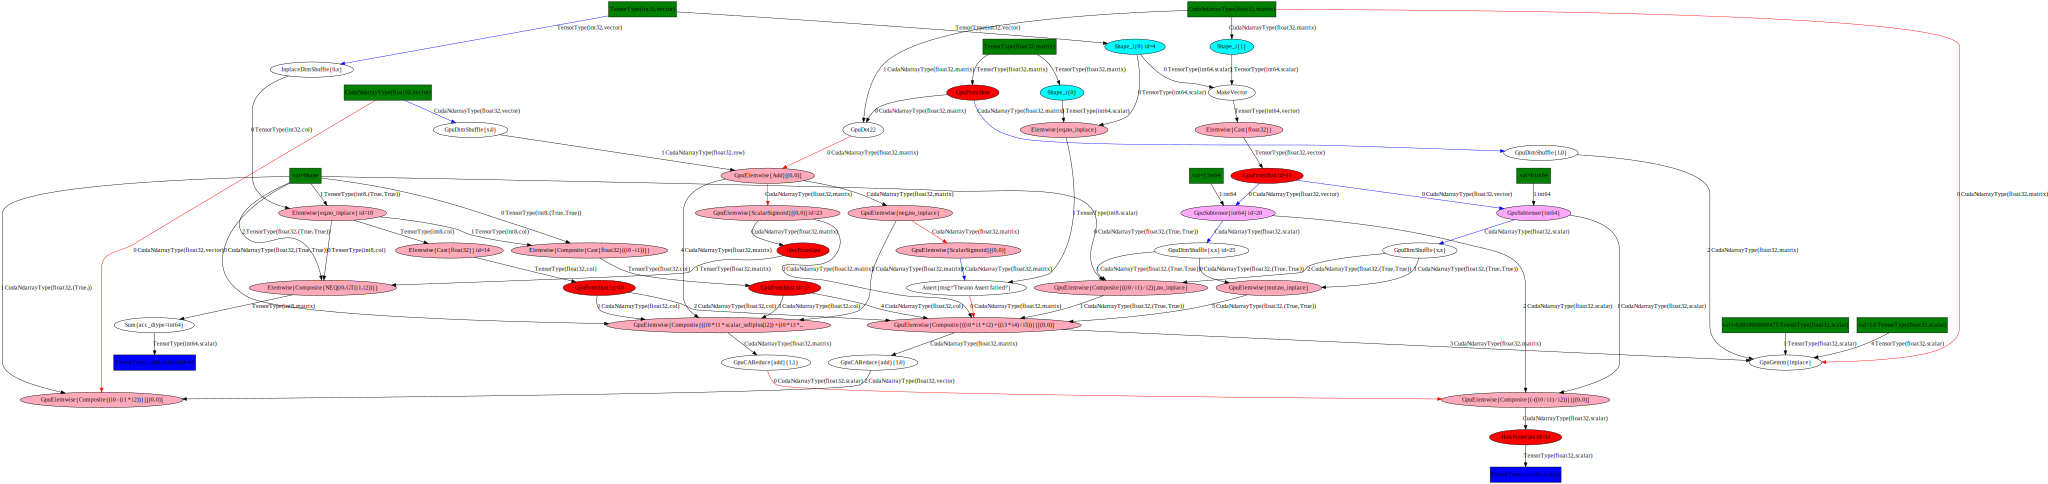

In [82]:
svgdotprint(train_fun)

In [85]:
for step in xrange(100000):
    batch_idx = np.random.random_integers(0, trainX.shape[0]-1, 1000) #index of train samples for this iter
    batchX = np.take(trainX, batch_idx, axis=0)
    batchY = np.take(trainY, batch_idx, axis=0)
    nll, err = train_fun(batchX, batchY)
    if (step%1000)==0:
        print step, nll, err
    
    if (step%1000)==0:
        testPreds = is_one(testX).ravel()
        testErrs = ((testY==1) != testPreds).sum()
        print "test errs: ", testErrs

0 0.135152593255 25
test errs:  200
1000 0.133246645331 30
test errs:  190
2000 0.121706545353 20
test errs:  179
3000 0.108372025192 22
test errs:  173
4000 0.115951508284 24
test errs:  165
5000 0.103434242308 10
test errs:  156
6000 0.114383324981 28
test errs:  156
7000 0.105613715947 19
test errs:  152
8000 0.100954905152 16
test errs:  150
9000 0.101504124701 21
test errs:  146
10000 0.0931702852249 13
test errs:  143
11000 0.0976519659162 19
test errs:  139
12000 0.0929547697306 17
test errs:  135
13000 0.0994606986642 23
test errs:  132
14000 0.0976180955768 21
test errs:  132
15000 0.0870763882995 21
test errs:  130
16000 0.0692994147539 8
test errs:  130
17000 0.0772057250142 16
test errs:  129


KeyboardInterrupt: 

<matplotlib.colorbar.Colorbar instance at 0x7f7c4cd0f560>

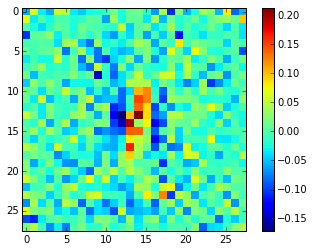

In [86]:
plt.imshow(W.get_value().reshape(28,28), interpolation='nearest')
plt.colorbar()

## Dlaczego wszędzie chcemy float32?

Theano potrafi generować kod w C do obliczeń wykorzystujcych CPU i kod w CUDA do obliczeń na GPU. Garty dla graczy zwykle zoptymalizowane są z myślą o obliczeniach we float32. Dodatkowo, uczenie sieci neuronowych nie wymaga pracyzju float64. Ponadto, osczędzamy trochę pamięci.

W starych wersjach Theano funkcje kompilowane na GPU obsługiwały jedynie obliczenia w float32. W nowszej (testowej) implementacji możemy na GPU korzystać z float16, float32 i float64. Sam sprzęt jest jednak najwydajniejszy dla float32.

Domyślny typ liczb zmiennoprzecinkowych możemy ustawiać flagą konfiguracyjną Theano config.floatX: http://deeplearning.net/software/theano/library/config.html

## Budujemy sieć neuronową

In [61]:
from theano.tensor.shared_randomstreams import RandomStreams

In [100]:
theano.config.compute_test_value = 'warn' #właczamy

X = TT.matrix('X') #zmienne niezależne - minibatch
X.tag.test_value = trainX[:2,:] #weźmiemy tylko dwie wartości, żeby szybko sie liczyło

Y = TT.ivector() #Y będzie typu integer
Y.tag.test_value = trainY[:2]

parameters = []
layers = [] #will be needed for dropout

# zaczynamy od wejść
L = X
last_dim = trainX.shape[1]
for hl_num, hl_size in enumerate([800, 800]):
    W = theano.shared((np.random.rand(last_dim, hl_size)*0.01-0.005).astype(np.float32),
                     name='W_%d' % (hl_num))

    # biasy - znów dla jednego wyjścia
    b = theano.shared(np.zeros((hl_size,), dtype=np.float32),
                     name='b_%d' % (hl_num))
    parameters.extend([W,b])
    
    L = L.dot(W) + b
    L = TT.maximum(0, L) #ReLU activation
    layers.append(L)
    last_dim = hl_size
    
## warstwa wyjściowa:
W = theano.shared((np.random.rand(last_dim, 10)*0.01-0.005).astype(np.float32),
                     name='W_out')
# biasy - znów dla jednego wyjścia
b = theano.shared(np.zeros((10,), dtype=np.float32),
                     name='b_out')

parameters.extend([W,b])
L = L.dot(W) + b
p_y_given_x = TT.nnet.softmax(L) #ReLU activation

In [101]:
parameters

[W_0:CudaNdarrayType(float32, matrix),
 b_0:CudaNdarrayType(float32, vector),
 W_1:CudaNdarrayType(float32, matrix),
 b_1:CudaNdarrayType(float32, vector),
 W_out:CudaNdarrayType(float32, matrix),
 b_out:CudaNdarrayType(float32, vector)]

In [102]:
p_y_given_x.tag.test_value

Shape: (2, 10)
[[ 0.10000848  0.1000341   0.10003663  0.09997744  0.10001019  0.09995852
   0.10000192  0.09997851  0.09999165  0.10000257]
 [ 0.10000823  0.10002995  0.10003844  0.09996197  0.10001402  0.09996747
   0.09999985  0.09996491  0.09999809  0.10001708]]

In [103]:
pred_y_given_x = TT.argmax(p_y_given_x, axis=1)
pred_y_given_x.tag.test_value

Shape: (2,)
[2 2]

In [104]:
classify = theano.function([X], pred_y_given_x)

## Dodajemy dropout

Dropout polega na wyłaczeniu pewnego losowego podzbioru neuronów w każdej z warstw. Możemy go zaimplementować jako mnożenie przez losową macierz 0-1. 

Zamiast modyfikować kod implementujący sieć, podmienimy w Theano węzły każdej z warstw na mnożenie z losową macierzą. W ten sposób możemy zaimplementować dropout dla wszystkich możliwych modeli.

In [105]:
ret=None
if len(layers)<2:
    ret=svgdotprint(p_y_given_x)
ret

In [106]:
from theano.tensor.shared_randomstreams import RandomStreams
ret=None
rng = RandomStreams()
input_dropout=0.2
dropout = 0.5
if dropout>0:
    replacements = []
    
    if input_dropout>0:
        print 'ss'
        mask = rng.uniform((X.shape[0],X.shape[1])) >= input_dropout
        mask /= (1.0-input_dropout)
        replacements.append((X, X*mask))
    
    for l in layers:
        mask = rng.uniform((l.shape[0],l.shape[1])) >= dropout
        mask /= (1.0-dropout)
        replacements.append((l, l*mask))

    p_y_given_x = theano.clone(p_y_given_x, replace=replacements)
    pred_y_given_x = theano.clone(pred_y_given_x, replace=replacements)
    if len(layers)<2:
        ret=svgdotprint(p_y_given_x)
ret

ss


In [107]:
neg_ll = -TT.log(p_y_given_x[TT.arange(Y.shape[0]), Y]).mean() # log z prawdopodobienstw przypisanym poprawnym klasom

In [108]:
loss = neg_ll

#for p in parameters:
#    if p.name.startswith('W'):
#        loss = loss + 1e-4*(p**2).sum()

In [109]:
errs = TT.neq(Y, pred_y_given_x).sum()

In [110]:
d_loss_d_parameters = theano.grad(loss, parameters)

In [111]:
num_steps = theano.shared(np.array(0, dtype=np.float32))
lrate_sched = [(num_steps, num_steps+1)]

In [112]:
K = 3000
lrate = (K*0.3)/TT.maximum(K, num_steps)

In [113]:
learn_rule = []

for p, dl_dp in zip(parameters, d_loss_d_parameters):
    p_new = p- lrate*dl_dp
    if p.name.startswith('W'):
        p_new_col_norms = TT.sqrt((p_new**2).sum(0, keepdims=True))
        p_new = p_new / TT.switch(p_new_col_norms>1.0, p_new_col_norms, 1.0)
    learn_rule.append((p,p_new))
    

In [114]:
train_fun = theano.function([X,Y], (loss, errs), updates=learn_rule+lrate_sched)

In [115]:
batch_errs = []
for step in xrange(100000):
    batch_idx = np.random.random_integers(0, trainX.shape[0]-1, 100) #index of train samples for this iter
    batchX = np.take(trainX, batch_idx, axis=0)
    batchY = np.take(trainY, batch_idx, axis=0)
    nll, err = train_fun(batchX, batchY)
    batch_errs.append((nll,err))
    if (step%50)==0:
        nll, err = np.asarray(batch_errs).mean(0)
        batch_errs = []
        print step, nll, err ,'%%'
    
    if (step%1000)==0:
        testPreds = classify(testX)
        testErrs = (testY != testPreds).mean()
        print "test errs: ", testErrs*100, '%%'

0 2.30257987976 95.0 %%
test errs:  89.9 %%
50 2.29752333164 87.26 %%
100 1.66333782554 58.24 %%
150 0.599581331611 18.92 %%
200 0.361875680089 10.64 %%
250 0.316401032805 9.22 %%
300 0.284721823037 8.74 %%
350 0.25609244138 7.62 %%
400 0.234181158245 6.54 %%
450 0.212472470552 5.92 %%
500 0.194286559969 5.86 %%
550 0.204885071069 5.96 %%
600 0.205114082694 5.66 %%
650 0.164034750313 4.44 %%
700 0.161216153055 4.7 %%
750 0.158288211897 4.58 %%
800 0.154040496498 4.26 %%
850 0.14622402437 3.86 %%
900 0.149899998754 4.12 %%
950 0.152941461653 4.1 %%
1000 0.133165308386 3.86 %%
test errs:  4.04 %%
1050 0.125808657147 3.68 %%
1100 0.113890041262 3.4 %%
1150 0.10952644065 3.18 %%
1200 0.109599674381 3.6 %%
1250 0.139885922447 3.84 %%
1300 0.0973279761523 2.84 %%
1350 0.111118956581 2.86 %%
1400 0.100540672932 3.08 %%
1450 0.109885300715 2.88 %%
1500 0.0989344232902 2.6 %%
1550 0.107042226978 3.28 %%
1600 0.121921634637 2.86 %%
1650 0.0767285779491 2.44 %%
1700 0.106637279205 2.66 %%
1750 0.

KeyboardInterrupt: 

## Liczby losowe w Theano

Liczby losowe wykorzystują mechanizm shared variables: z każdego strumienia liczb losowych wykonywane jest jedno losowanie na wykonanie funkcji (chyba że losujemy wewnątrz scan). Zmiana stany generatora liczb losowych nastepuje niejawnie przez mechanizm `updates`.

In [116]:
from theano.tensor.shared_randomstreams import RandomStreams

srng = RandomStreams(seed=234)
rv_u = srng.uniform((2,2))
rv_n = srng.normal((2,2))

In [117]:
f = theano.function([], rv_u)

In [122]:
f()

Shape: (2, 2)
[[ 0.70574272  0.80222458]
 [ 0.25976163  0.18285403]]

In [123]:
g = theano.function([], rv_n, no_default_updates=True)    #Not updating rv_n.rng

In [127]:
g()

Shape: (2, 2)
[[ 0.37328446 -0.65746671]
 [-0.36302373 -0.97484624]]

In [128]:
nearly_zeros = theano.function([], rv_u + rv_u - 2 * rv_u) #liczby losowane są raz na wykonanie funkcji - potem wszystkie odwołania są identyczne

In [131]:
nearly_zeros()

Shape: (2, 2)
[[ 0.  0.]
 [ 0.  0.]]

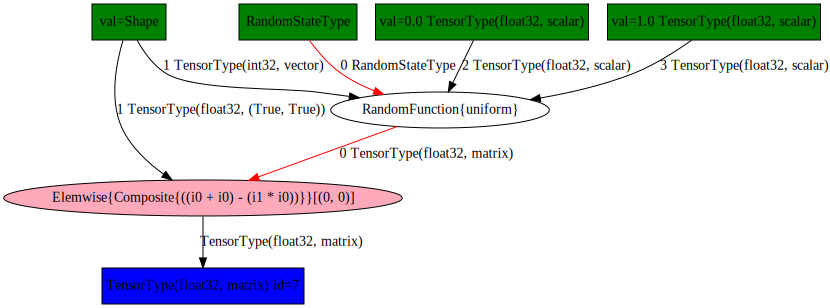

In [132]:
svgdotprint(nearly_zeros)

In [133]:
# nieco szybsza implementacja liczb losowych

from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

srng = RandomStreams(seed=234)
rv_u = srng.uniform((2,2))

f = theano.function([], rv_u)

/home/jch/scratch/speech/libs/Theano/theano/sandbox/rng_mrg.py:53: UserWarning: Warning, Cannot compute test value: input 0 (A) of Op <theano.sandbox.rng_mrg.DotModulo object at 0x7fce427b1f90>(A, s, m, A2, s2, m2) missing default value
  o = DotModulo()(A_sym, s_sym, m_sym, A2_sym, s2_sym, m2_sym)
/home/jch/scratch/speech/libs/Theano/theano/sandbox/rng_mrg.py:53: UserWarning: Warning, Cannot compute test value: input 1 (s) of Op <theano.sandbox.rng_mrg.DotModulo object at 0x7fce427b1f90>(A, s, m, A2, s2, m2) missing default value
  o = DotModulo()(A_sym, s_sym, m_sym, A2_sym, s2_sym, m2_sym)
/home/jch/scratch/speech/libs/Theano/theano/sandbox/rng_mrg.py:53: UserWarning: Warning, Cannot compute test value: input 2 (m) of Op <theano.sandbox.rng_mrg.DotModulo object at 0x7fce427b1f90>(A, s, m, A2, s2, m2) missing default value
  o = DotModulo()(A_sym, s_sym, m_sym, A2_sym, s2_sym, m2_sym)
/home/jch/scratch/speech/libs/Theano/theano/sandbox/rng_mrg.py:53: UserWarning: Warning, Cannot comp

In [142]:
f()

Shape: (2, 2)
[[ 0.2188075   0.12655717]
 [ 0.1793364   0.93523318]]

## Pętle w Theano

Na razie wszystkie wyrażenia które budowaliśmy w Theano zakładały wykonanie takiej samej ilości operacji. Operacja `scan` pozwala na włączanie w graf obliczeń pętli.

In [143]:
help(theano.scan)

Help on function scan in module theano.scan_module.scan:

scan(fn, sequences=None, outputs_info=None, non_sequences=None, n_steps=None, truncate_gradient=-1, go_backwards=False, mode=None, name=None, profile=False, allow_gc=None, strict=False)
    This function constructs and applies a Scan op to the provided
    arguments.
    
    :param fn:
        ``fn`` is a function that describes the operations involved in one
        step of ``scan``. ``fn`` should construct variables describing the
        output of one iteration step. It should expect as input theano
        variables representing all the slices of the input sequences
        and previous values of the outputs, as well as all other arguments
        given to scan as ``non_sequences``. The order in which scan passes
        these variables to ``fn``  is the following :
    
        * all time slices of the first sequence
        * all time slices of the second sequence
        * ...
        * all time slices of the last sequen

In [144]:
theano.config.compute_test_value = 'off' #wyłaczamy


## Obliczanie wartości wielomianu - za http://deeplearning.net/software/theano/tutorial/loop.html
coefficients = TT.vector("coefficients")
x = TT.scalar("x")
max_coefficients_supported = 10000

# Generate the components of the polynomial
full_range = TT.arange(max_coefficients_supported)
components, updates = theano.scan(fn=lambda coeff, power, free_var:
                                  coeff * (free_var ** power),
                                  sequences=[coefficients, full_range],
                                  outputs_info=None,
                                  non_sequences=x)
polynomial = components.sum()
calculate_polynomial1 = theano.function(inputs=[coefficients, x],
                                        outputs=polynomial)

test_coeff = numpy.asarray([1, 0, 2], dtype=numpy.float32)
print(calculate_polynomial1(test_coeff, 3))

19.0


/home/jch/scratch/speech/libs/Theano/theano/gof/cmodule.py:294: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  rval = __import__(module_name, {}, {}, [module_name])


In [145]:
coefficients = TT.vector("coefficients")
x = TT.scalar("x")
max_coefficients_supported = 10000

# Generate the components of the polynomial
full_range = TT.arange(max_coefficients_supported)


outputs_info = TT.as_tensor_variable(numpy.asarray(0, 'float64'))

components, updates = theano.scan(fn=lambda coeff, power, prior_value, free_var:
                                  prior_value + (coeff * (free_var ** power)),
                                  sequences=[coefficients, full_range],
                                  outputs_info=outputs_info,
                                  non_sequences=x)

polynomial = components[-1]
calculate_polynomial = theano.function(inputs=[coefficients, x],
                                       outputs=polynomial, updates=updates)

test_coeff = numpy.asarray([1, 0, 2], dtype=numpy.float32)
print(calculate_polynomial(test_coeff, 3))

19.0
